# Sentinel-2

#### Sentinel-2 is an Earth observation mission from the EU Copernicus Programme that systematically acquires optical imagery at high spatial resolution (up to 10 m for some bands). The mission is based on a constellation of two identical satellites in the same orbit, 180° apart for optimal coverage and data delivery. Together, they cover all Earth's land surfaces, large islands, inland and coastal waters every 3-5 days.

#### Sentinel-2A was launched on 23 June 2015 and Sentinel-2B followed on 7 March 2017. Both of the Sentinel-2 satellites carry an innovative wide swath high-resolution multispectral imager with 13 spectral bands. For more information on the Sentinel-2 platforms and applications, check out the [European Space Agency website](http://www.esa.int/Applications/Observing_the_Earth/Copernicus/Overview4).

#### Digital Earth Australia (DEA) applies corrections to Sentinel-2 satellite images to arrive at a [surface reflectance](https://cmi.ga.gov.au/ga_s2_m_nbart_1) product (see the [introduction to Digtial Earth Australia](../Beginners_guide/02_DEA.ipynb) section for more information on the surface reflectance corrections). Surface reflectance provides standardised optical datasets by using robust physical models to correct for variations in image radiance values due to atmospheric properties, as well as sun and sensor geometry. The resulting stack of surface reflectance grids are consistent over space and time, which is instrumental in identifying and quantifying environmental change.

#### DEA provides two Sentinel-2 surface reflectance products:

1. **Sentinel-2 Definitive** (e.g. `s2a_ard_granule`): These products represent the 'definitive' source of high quality Sentinel-2 surface reflectance data, and are available from the beginning of the Sentinel-2 archive up to a delay of several weeks. 

2. **Sentinel-2 Near Real Time** (e.g. `s2a_nrt_granule`): These products are processed with best-available ancillary information and provided as a rolling 90 day archive of imagery which is typically available to load within approximately ~24 hours of a satellite overpass.

#### Both Sentinel-2 Definitive and Sentinel-2 Near Real Time products contain data processed to two surface reflectance corrections:

1. **NBAR** (e.g. `nbar_green`): NBAR stands for Nadir-corrected BRDF Adjusted Reflectance, where BRDF stands for Bidirectional reflectance distribution function.
    The approach involves atmospheric correction to compute surface-leaving radiance and bi-directional reflectance modelling to remove the effects of topography and angular variation in reflectance.

2. **NBAR-T** (e.g. `nbart_green`): Surface reflectance NBAR-T includes the terrain illumination reflectance correction and has the same features of NBAR, along with some additional features.


#### Sentinel-2 surface reflectance products have 13 spectral channels:

| Sentinel-2 bands | DEA band name | Band number | Central wavelength (nm) | Resolution (m) | Bandwidth (nm) |
| -----------------|---------------|-------------|-------------------------|----------------|----------------|
| Coastal aerosol | `nbar(t)_coastal_aerosol` | 1 | 443 | 60 | 20 |
| Blue | `nbar(t)_blue` | 2 | 490 | 10 | 65 |
| Green | `nbar(t)_green` | 3 | 560 | 10 | 35 |
| Red | `nbar(t)_red` | 4 | 665 | 10 | 30 |
| Vegetation red edge | `nbar(t)_red_edge_1` | 5 | 705 | 20 | 15 |
| Vegetation red edge | `nbar(t)_red_edge_2` | 6 | 740 | 20 | 15 |
| Vegetation red edge | `nbar(t)_red_edge_3` | 7 | 783 | 20 | 20 |
| NIR | `nbar(t)_nir_1` | 8 | 842 | 10 | 115 |
| Narrow NIR | `nbar(t)_nir_2` | 8A | 865 | 20 | 20 |
| Water vapour | N/A | 9 | 945 | 60 | 20 |
| SWIR - Cirrus | N/A | 10 | 1375 | 60 | 20 |
| SWIR | `nbar(t)_swir_2` | 11 | 1610 | 20 | 90 |
| SWIR | `nbar(t)_swir_3` | 12 | 2190 | 20 | 180 |

#### These bands cover the visible, near-infrared and short-wave infrared wave lengths.

!['Sentinel-2 spectral bands'](http://www.geosage.com/highview/figures/Sentinel2_Spectral_Bands.jpg)
     
> **Note**: There are a number of additional datasets that are also returned as part of Sentinel-2 queries.
These are a combination of datasets used in the correction process, and layers relating to pixel quality.

#### Load packages and connect to the datacube

In [19]:
import sys
import datacube
import xarray as xr
from odc.ui import with_ui_cbk
from matplotlib import pyplot as plt

sys.path.append("./Scripts")
from dea_datahandling import load_ard
from dea_plotting import rgb
from dea_plotting import display_map
from datacube.utils.masking import make_mask

dc = datacube.Datacube(app="Sentinel_2")

#### We will load **Sentinel-2 Definitive** data from the Sentinel-2A and Sentinel-2B satellites using two methods. Firstly, we will use `dc.load()` to return a time series of satellite images from a single sensor. Secondly, we will load a time series using the `load_ard()` function, which is a wrapper function around the dc.load module. This function will load all the images from both Sentinel-2A and Sentinel-2B, combine them, and then apply a cloud mask. The returned `xarray.Dataset` will contain analysis ready images with the cloudy and invalid pixels masked out.

#### You can change any of the parameters in the `query` object below to adjust the location, time, projection, or spatial resolution of the returned datasets.

#### Sentinel-2 data is stored on file with a range of different coordinate reference systems or CRS (i.e. multiple UTM zones). The different satellite bands also have different resolutions (10 m, 20 m and 60 m).  Because of this, all Sentinel-2 queries need to include the following two query parameters:

* `output_crs`: This sets a consistent CRS that all Sentinel-2 data will be reprojected to, regardless of the UTM zone the individual image is stored in.
* `resolution`: This sets the resolution that all Sentinel-2 images will be resampled to. 

> Note: Be aware that setting `resolution` to the highest available resolution (i.e. `(-10, 10)`) will downsample the coarser resolution 20 m and 60 m bands, which may introduce unintended artefacts into your analysis.
It is typically best practice to set `resolution` to match the lowest resolution band being analysed. For example, if your analysis uses both 10 m and 20 m resolution bands, set `"resolution": (-20, 20)`.

In [3]:
# Create a query object
query = {
    "x": (153.45, 153.47),
    "y": (-28.90, -28.92),
    "time": ("2018-01", "2018-02"),
    "output_crs": "EPSG:3577",
    "resolution": (-10, 10),
    "group_by": "solar_day",
}

#### The two **Sentinel-2 Definitive** products are:

* `s2a_ard_granule`
* `s2b_ard_granule`

>Note: Here we will load in a time-series of satellite images from only Sentinel-2A. To load in images from Sentinel-2B, change the `product` variable to `'s2b_ard_granule'`.

In [4]:
ds = dc.load(product="s2a_ard_granule",
             progress_cbk=with_ui_cbk(),
             **query)

ds

<xarray.Dataset>
Dimensions:                (time: 6, x: 228, y: 255)
Coordinates:
  * time                   (time) datetime64[ns] 2018-01-06T23:52:41.026000 ....
  * y                      (y) float64 -3.313e+06 -3.313e+06 ... -3.316e+06
  * x                      (x) float64 2.057e+06 2.057e+06 ... 2.059e+06
    spatial_ref            int32 3577
Data variables:
    azimuthal_exiting      (time, y, x) float32 -160.90376 ... -29.190119
    azimuthal_incident     (time, y, x) float32 170.4605 ... -25.479986
    exiting                (time, y, x) float32 1.9511385 2.391956 ... 5.8774323
    incident               (time, y, x) float32 25.019077 25.188375 ... 38.39617
    relative_azimuth       (time, y, x) float32 16.493828 ... 37.642647
    relative_slope         (time, y, x) float32 -28.635742 ... 3.7101326
    satellite_azimuth      (time, y, x) float32 99.85303 99.85302 ... 99.85423
    satellite_view         (time, y, x) float32 4.5394645 ... 4.2476106
    solar_azimuth          (time, y, x) float32 83.3592 83.35906 ... 62.211586
    solar_zenith           (time, y, x) float32 27.643938 27.643759 ... 35.8065
    terrain_shadow         (time, y, x) uint8 1 1 1 1 1 1 1 1 ... 1 1 1 1 1 1 1
    fmask                  (time, y, x) uint8 1 1 1 1 1 1 1 1 ... 2 2 2 2 2 2 2
    nbar_contiguity        (time, y, x) uint8 1 1 1 1 1 1 1 1 ... 1 1 1 1 1 1 1
    nbar_coastal_aerosol   (time, y, x) int16 338 338 338 338 ... 1944 1944 2122
    nbar_blue              (time, y, x) int16 260 305 326 321 ... 1655 1761 1810
    nbar_green             (time, y, x) int16 517 612 648 680 ... 1805 1867 1859
    nbar_red               (time, y, x) int16 260 288 303 305 ... 1699 1735 1751
    nbar_red_edge_1        (time, y, x) int16 764 918 918 946 ... 2220 2220 2261
    nbar_red_edge_2        (time, y, x) int16 2644 3112 3112 ... 3156 3156 3118
    nbar_red_edge_3        (time, y, x) int16 3645 4086 4086 ... 3622 3622 3493
    nbar_nir_1             (time, y, x) int16 4370 4319 4310 ... 3900 3933 3861
    nbar_nir_2             (time, y, x) int16 4216 4544 4544 ... 3882 3882 3807
    nbar_swir_2            (time, y, x) int16 1625 1794 1794 ... 2670 2670 2668
    nbar_swir_3            (time, y, x) int16 617 718 718 701 ... 2238 2238 2275
    nbart_contiguity       (time, y, x) uint8 1 1 1 1 1 1 1 1 ... 1 1 1 1 1 1 1
    nbart_coastal_aerosol  (time, y, x) int16 333 333 333 333 ... 1914 1914 2132
    nbart_blue             (time, y, x) int16 256 299 320 317 ... 1696 1811 1863
    nbart_green            (time, y, x) int16 508 602 638 671 ... 1849 1919 1912
    nbart_red              (time, y, x) int16 255 283 298 301 ... 1742 1786 1803
    nbart_red_edge_1       (time, y, x) int16 751 903 903 934 ... 2271 2271 2322
    nbart_red_edge_2       (time, y, x) int16 2598 3061 3061 ... 3229 3229 3202
    nbart_red_edge_3       (time, y, x) int16 3586 4023 4023 ... 3700 3700 3582
    nbart_nir_1            (time, y, x) int16 4301 4249 4246 ... 3994 4041 3970
    nbart_nir_2            (time, y, x) int16 4148 4475 4475 ... 3967 3967 3905
    nbart_swir_2           (time, y, x) int16 1596 1764 1764 ... 2733 2733 2742
    nbart_swir_3           (time, y, x) int16 605 706 706 691 ... 2293 2293 2340
Attributes:
    crs:           EPSG:3577
    grid_mapping:  spatial_ref

The returned dataset contains all of the bands available for Sentinel-2.
These include both `NBAR` and `NBAR-T` versions of the optical bands, along with [fmask](../Frequently_used_code/Masking_data.ipynb) (used for cloud masking) and other measurements (e.g. `azimuthal_exiting`, `azimuthal_incident`) that are used for generating the surface reflectance product.

Usually we are not interested in returning all the possible bands, but instead are only interested in a subset of these.
If we wished to return only a few of `NBAR-T` optical bands, then we would pass a `measurements` parameter to `dc.load()` (or, alternatively, amend the initial `query` object to have a `measurements` parameter). 

In [5]:
bands = ["nbart_blue", "nbart_green", "nbart_red"]

ds = dc.load(product="s2a_ard_granule",
             measurements=bands,
             progress_cbk=with_ui_cbk(),
             **query)

ds

<xarray.Dataset>
Dimensions:      (time: 6, x: 228, y: 255)
Coordinates:
  * time         (time) datetime64[ns] 2018-01-06T23:52:41.026000 ... 2018-02...
  * y            (y) float64 -3.313e+06 -3.313e+06 ... -3.316e+06 -3.316e+06
  * x            (x) float64 2.057e+06 2.057e+06 ... 2.059e+06 2.059e+06
    spatial_ref  int32 3577
Data variables:
    nbart_blue   (time, y, x) int16 256 299 320 317 312 ... 1611 1696 1811 1863
    nbart_green  (time, y, x) int16 508 602 638 671 654 ... 1802 1849 1919 1912
    nbart_red    (time, y, x) int16 255 283 298 301 298 ... 1711 1742 1786 1803
Attributes:
    crs:           EPSG:3577
    grid_mapping:  spatial_ref

#### Let's plot the facetted contents of this Sentinel-2 dataset:

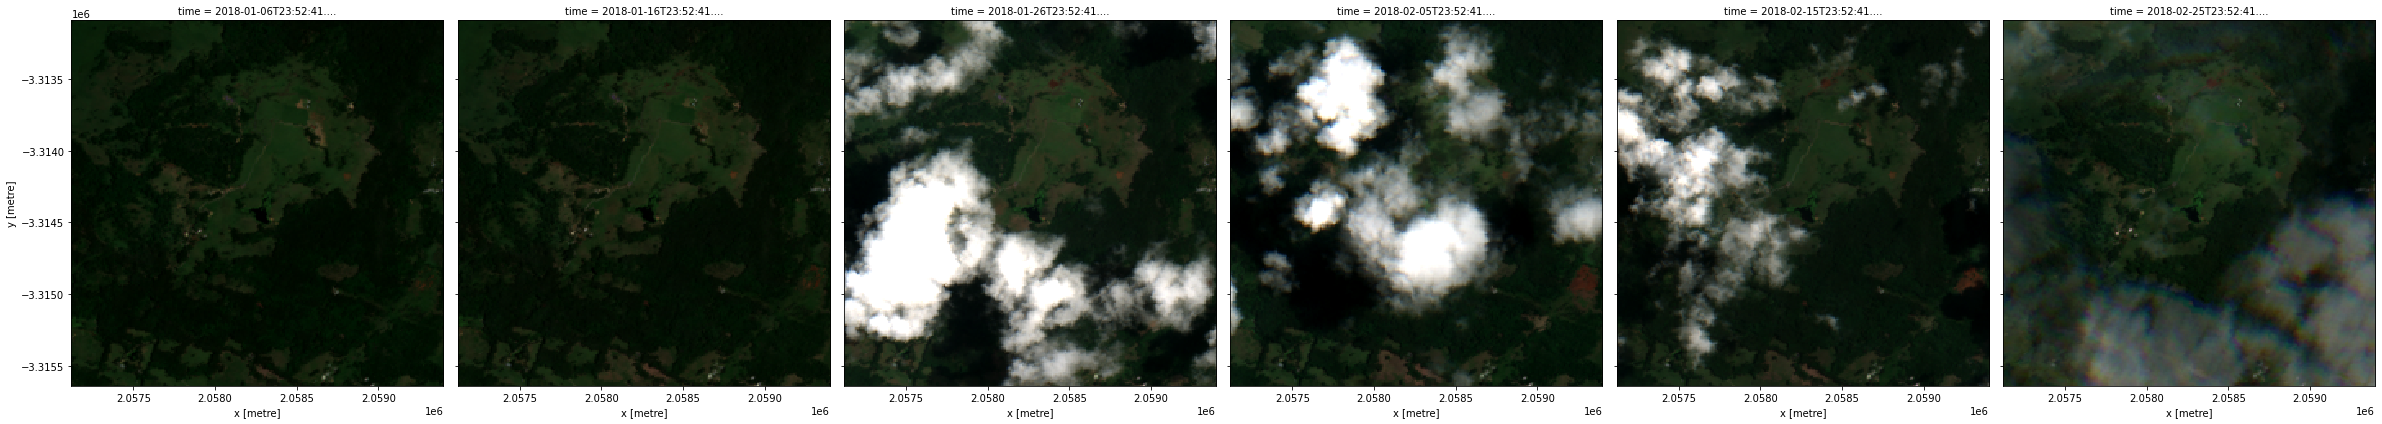

In [6]:
rgb(ds, col="time", col_wrap=6)

#### The often called agriculture RGB composite, uses bands SWIR-2, near-infrared and blue. It’s mostly used to monitor crop health, as both short-wave and near infrared bands are particularly good at highlighting dense vegetation, which appears dark green in the composite. SWIR measurements can help scientists estimate how much water is present in plants and soil, as water reflects SWIR light. Shortwave-infrared bands are also useful for distinguishing between snow, and ice, all of which appear white in visible light. Newly burned land reflects strongly in SWIR bands, making them valuable for mapping fire damage.

#### Exercise xxx: Can you create an "agriculture RGB composite of the previous images.

> Tip: You might need to load new data specifying these bands. Remember that you can specify a `bands` parameter in the `rgb()` with the list of bands to map to the RGB channels.

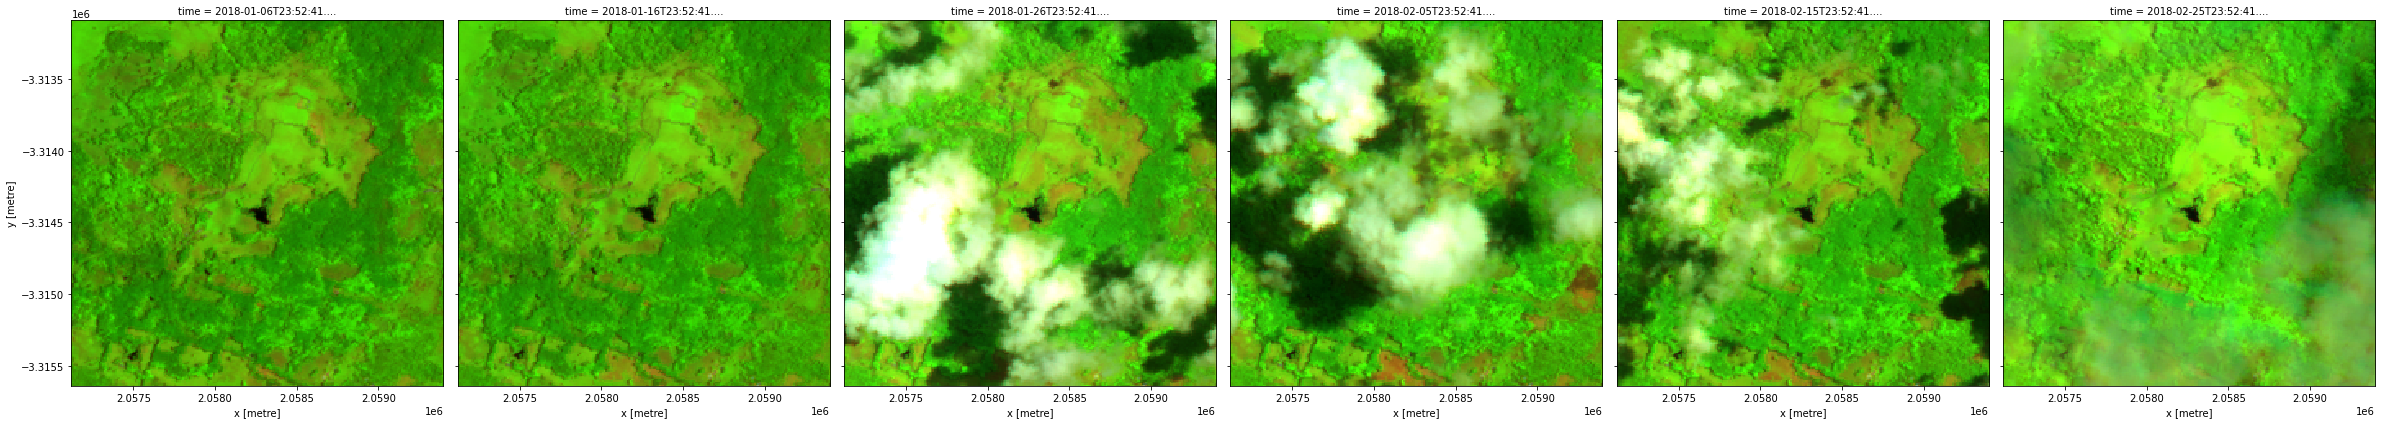

In [13]:
ds = ?

rgb(?)

#### Sentinel-2 ARD contains a variable called `fmask` with information relative to pixel quality. The `fmask` variable contains values from 0 to 5, using a similar encoding to Landsat.

| Value | Description |
|-------|-------------|
| 0 | Null |
| 1 | Valid |
| 2 | Cloud |
| 3 | Cloud shadow |
| 4 | Snow |
| 5 | Water |

#### Exercise xxx: Can you choose an area containing a water body and use the `fmask` variable to filter anything that is not classified as water in the images?

> Note: You can visualise the evolution of water bodies over a period of time. Would you know how to calculate the evolution of the surface or extent covered by water through time?

In [ ]:
ds = ?

#### Alternatively to the previous method, DEA offers the `load_ard()` function to load Sentinel-2 data more conveniently. This function will load images from both Sentinel-2A and Sentinel-2B, concatenate and sort the observations by time, and apply cloud masking.

#### For example:

In [15]:
bands = ["nbart_blue", "nbart_green", "nbart_red"]

ds = load_ard(dc=dc,
              products=["s2a_ard_granule", "s2b_ard_granule"],
              measurements=bands,
              **query)

ds

Finding datasets
    s2a_ard_granule
    s2b_ard_granule
Applying pixel quality/cloud mask
Loading 12 time steps


<xarray.Dataset>
Dimensions:      (time: 12, x: 228, y: 255)
Coordinates:
  * x            (x) float64 2.057e+06 2.057e+06 ... 2.059e+06 2.059e+06
  * time         (time) datetime64[ns] 2018-01-01T23:52:39.027000 ... 2018-02...
  * y            (y) float64 -3.313e+06 -3.313e+06 ... -3.316e+06 -3.316e+06
    spatial_ref  int32 3577
Data variables:
    nbart_blue   (time, y, x) float32 nan nan nan nan nan ... nan nan nan nan
    nbart_green  (time, y, x) float32 nan nan nan nan nan ... nan nan nan nan
    nbart_red    (time, y, x) float32 nan nan nan nan nan ... nan nan nan nan
Attributes:
    crs:           EPSG:3577
    grid_mapping:  spatial_ref

In [16]:
rgb(ds, col='time', col_wrap=6)

#### As you can see in the previous images, cloud masking in Sentinel-2 is not as reliable as in Landsat data. Improving the quality of cloud masking is a work in progress and you'll see an alternative solution later in this notebook.

#### Sentinel-2 Near Real Time (NRT): The surface reflectance processing workflow for Sentinel-2 Definitive products typically causes a delay before this data is available to load through the datacube.

#### To address this delay, DEA also provides a Sentinel-2 Near Real Time product which is available to load as early as ~24 hours after a satellite observation is made. Near Real Time data is processed using best-available ancillary information to provide atmospheric corrections, and delivered as a rolling 90 day archive of imagery.

#### The two Sentinel-2 NRT products are:

* `s2a_nrt_granule`
* `s2b_nrt_granule`

#### We can load Sentinel-2 NRT using either `dc.load()` or `load_ard()` using the methods demonstrated above:

In [17]:
query = {
    "x": (153.45, 153.47),
    "y": (-28.90, -28.92),
    "measurements": ["nbart_blue", "nbart_green", "nbart_red"],
    "output_crs": "EPSG:3577",
    "resolution": (-10, 10),
    "group_by": "solar_day",
}

ds = load_ard(dc=dc,
              products=["s2a_nrt_granule", "s2b_nrt_granule"],
              mask_pixel_quality=False,
              **query)

ds

Finding datasets
    s2a_nrt_granule
    s2b_nrt_granule
Loading 17 time steps


<xarray.Dataset>
Dimensions:      (time: 17, x: 228, y: 255)
Coordinates:
  * x            (x) float64 2.057e+06 2.057e+06 ... 2.059e+06 2.059e+06
  * time         (time) datetime64[ns] 2020-06-04T23:54:44.714480 ... 2020-08...
  * y            (y) float64 -3.313e+06 -3.313e+06 ... -3.316e+06 -3.316e+06
    spatial_ref  int32 3577
Data variables:
    nbart_blue   (time, y, x) int16 380 400 470 423 441 ... 544 516 511 411 290
    nbart_green  (time, y, x) int16 619 643 826 843 847 ... 768 719 708 523 318
    nbart_red    (time, y, x) int16 480 567 564 508 521 ... 790 730 739 501 271
Attributes:
    crs:           EPSG:3577
    grid_mapping:  spatial_ref

#### We can now plot the most recently acquired Sentinel-2 image in our dataset:

In [18]:
# `index=-1` selects the final image in the dataset
rgb(ds, index=-1, size=8)

#### Exercise xxx: Try to get the most recent image available for the place you choose in Australia.

In [ ]:
ds = ?

#### Exercise xxxx: Use the facetted plots to display the evolution of the selected area using the "agriculture" false colour representation.

> Hint: It might help to choose a sunny agricultural region to visualise the evolution of crops during the past 3 months.

In [ ]:
ds = ?

#### `TSmask` is a time series cloud and cloud shadow detection algorithm for Sentinel-2 surface reflectance data.  `TSmask` models time series of surface reflectance derived indices and calculates time series abnormality coefficients for pixels in the time series. `TSmask` does not rely on predefined training data to generate complex models with many rule sets, which often work well for data similar to the training data while return poor results for data contrasting to the training data. Instead, `TSmask` identifies cloud and cloud shadows by detecting local abnormalities in temporal and spatial contexts from abnormality coefficients.

#### The `TSmask` analysis algorithm classifies each Sentinel-2 pixel into one of four distinctive categories:

* 0 = No observation
* 1 = Clear
* 2 = Cloud
* 3 = Cloud shadow

#### `TSmask` is available in DEA in a product called `s2_tsmask`. We can inspect its features using `dc.list_measurements()`:

In [19]:
dc.list_measurements().loc['s2_tsmask']

name  dtype units nodata aliases  \
measurement                                                  
classification  classification  uint8     1      0     NaN   

                                                 flags_definition  \
measurement                                                         
classification  {'classification': {'bits': [0, 1, 2, 3, 4, 5,...   

               spectral_definition  
measurement                         
classification                 NaN

#### Let's compare results from `TSmask` with the default `fmask` cloud mask that is packaged with Sentinel 2 data, we can load matching data from both datasets from the datacube for the same sample location. In this example, we will use the urban area of Canberra:

In [5]:
query = {
    'y': (-35.28, -35.34),
    'x': (149.12, 149.18),
    'time': ('2018-01', '2018-03'),
    'output_crs': 'EPSG:3577',
    'resolution': (-20, 20)
}

display_map(x=query['x'], y=query['y'])

#### We now load data from both datasets. Unlike Sentinel 2 ARD data which is provided in seperate products for Sentinel-2A and 2B, the `s2_tsmask` product is provided as a single dataset that includes classifications for both Sentinel-2A and 2B. Because of this, it can be useful to concatenate Sentinel-2 ARD data into a single combined dataset for subsequent analyses.

> Note: This step can take several minutes to complete; please be patient. 

In [8]:
# Load in temporal cloudmask data
tsmask_ds = dc.load(product='s2_tsmask', 
                    progress_cbk=with_ui_cbk(),
                    **query)

# Load in Sentinel-2A and 2B data including fmask cloud masking band
s2a_ds = dc.load(
    product='s2a_ard_granule',
    measurements=['fmask', 'nbart_red', 'nbart_green', 'nbart_blue'],
    progress_cbk=with_ui_cbk(),
    **query)

s2b_ds = dc.load(
    product='s2b_ard_granule',
    measurements=['fmask', 'nbart_red', 'nbart_green', 'nbart_blue'],
    progress_cbk=with_ui_cbk(),
    **query)

# Combine Sentinel-2A and 2B data into a single dataset
s2_ds = xr.concat([s2a_ds, s2b_ds], dim='time').sortby('time')

#### We now print the output `tsmask_ds` object to view the contents of the dataset:

In [9]:
tsmask_ds

<xarray.Dataset>
Dimensions:         (time: 18, x: 316, y: 368)
Coordinates:
  * time            (time) datetime64[ns] 2018-01-05T00:02:29.027000 ... 2018...
  * y               (y) float64 -3.957e+06 -3.957e+06 ... -3.965e+06 -3.965e+06
  * x               (x) float64 1.549e+06 1.549e+06 ... 1.555e+06 1.555e+06
    spatial_ref     int32 3577
Data variables:
    classification  (time, y, x) uint8 1 1 1 1 1 1 1 1 1 1 ... 1 2 2 2 2 2 2 2 2
Attributes:
    crs:           EPSG:3577
    grid_mapping:  spatial_ref

#### The dataset has a single varible called `classification`, which contains the cloud and cloud shadow masking data.

#### The `classification` band contains flag information that classifies each pixel into no data, valid, cloudy and cloud shadowed observations:

In [10]:
tsmask_ds.classification.flags_definition

{'classification': {'bits': [0, 1, 2, 3, 4, 5, 6, 7],
  'values': {'0': 'nodata', '1': 'valid', '2': 'cloud', '3': 'shadow'},
  'description': 'TSmask classification'}}

#### We can use this same function to display the values used in the `fmask` variable:

In [11]:
s2_ds.fmask.flags_definition

{'fmask': {'bits': [0, 1, 2, 3, 4, 5, 6, 7],
  'values': {'0': 'nodata',
   '1': 'valid',
   '2': 'cloud',
   '3': 'shadow',
   '4': 'snow',
   '5': 'water'},
  'description': 'Fmask'}}

#### Due to differences in the processing pipelines used to generate Sentinel-2 ARD data and `TSmask`, there may be a different number of observations returned for both of these datasets. The following step can be useful for ensuring that both datasets contain exactly the same observations:

In [12]:
matching_times = (tsmask_ds.time - s2_ds.time).time
tsmask_ds = tsmask_ds.sel(time=matching_times)
s2_ds = s2_ds.sel(time=matching_times)

#### To compare classifications generated by `TSmask` against the default Sentinel 2 `fmask` classification, we can create a mask using the `make_mask` function from `datacube.storage.masking` and sum up all of the times a pixel was flagged as cloud in both datasets.

#### To make it easier to plot, we concatenate both of these summed datasets into a single combined dataset:

In [16]:
# TSmask and fmask cloud masks
tsmask_cloud = make_mask(tsmask_ds.classification, classification="cloud")
fmask_cloud = make_mask(s2_ds.fmask, fmask="cloud")

# Sum all cloudy pixels
tsmask_cloud_sum = tsmask_cloud.sum(dim='time')
fmask_cloud_sum = fmask_cloud.sum(dim='time')

# Combine into a single dataset and plot
combined_ds = xr.concat([tsmask_cloud_sum, fmask_cloud_sum], dim='cloudmask')
combined_ds = combined_ds.assign_coords(cloudmask=['tsmask', 'fmask'])
combined_ds.plot(col='cloudmask', size=6.5, aspect=1)

#### In a similar way, we can compare cloud shadow counts in both datasets:

In [17]:
# TSmask and fmask cloud masks
tsmask_shadow = make_mask(tsmask_ds.classification,
                          classification="shadow")
fmask_shadow = make_mask(s2_ds.fmask, fmask="shadow")

# Sum all cloudy pixels
tsmask_shadow_sum = tsmask_shadow.sum(dim='time')
fmask_shadow_sum = fmask_shadow.sum(dim='time')

# Combine into a single dataset and plot
combined_ds = xr.concat([tsmask_shadow_sum, fmask_shadow_sum], dim='cloudmask')
combined_ds = combined_ds.assign_coords(cloudmask=['tsmask', 'fmask'])
combined_ds.plot(col='cloudmask', size=6.5, aspect=1)

#### For a final comparison of both classifications, we can generate a cloud free composite image by masking our Sentinel-2 satellite bands with `TSmask` and `fmask` cloud and cloud shadow masks.

#### First, we generate a mask that will have a `True` value for any pixel that includes valid data. Because `fmask` has an additional `water` and `snow` flags, we need to include these to generate a comparable mask.

> Note: For this example we will generate a simple mean composite of each of the red, green and blue Sentinel-2 bands to highlight areas where clouds were poorly removed from the dataset.
For a more statistically reliable compositing method, refer to the [Generating geometric median composites (geomedians)](~/Frequently_used_code/Geomedian_composites.ipynb) notebook.

In [20]:
# Identify pixels that are either "valid", "water" or "snow"
cloud_free_mask = (make_mask(s2_ds.fmask, fmask="valid") |
                   make_mask(s2_ds.fmask, fmask="water") |
                   make_mask(s2_ds.fmask, fmask="snow"))

# Apply mask to RGB bands
s2_masked = s2_ds[['nbart_red', 'nbart_green',
                   'nbart_blue']].where(cloud_free_mask)

# Generate mean composite
s2_mean = s2_masked.mean(dim='time')

# Plot in RGB
rgb(s2_mean, size=12)
plt.title('Masking with fmask', fontdict={'fontsize': 20})

/env/lib/python3.6/site-packages/xarray/core/nanops.py:142: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


Text(0.5, 1.0, 'Masking with fmask')

#### Observe that the `fmask`-masked data contains several data gaps (bright white pixels) where urban areas are concistently mapped as cloud, and patchy areas of cloud and cloud shadow that was not captured in by `fmask`.

#### Now we can plot the same data with a mask generated from `TSmask` applied instead of `fmask`. Note that compared to the example above, the composite is clean and free of cloud or shadow, indicating that classification did a better job of removing these sources of noise from the time series. 

Text(0.5, 1.0, 'Masking with TSmask')

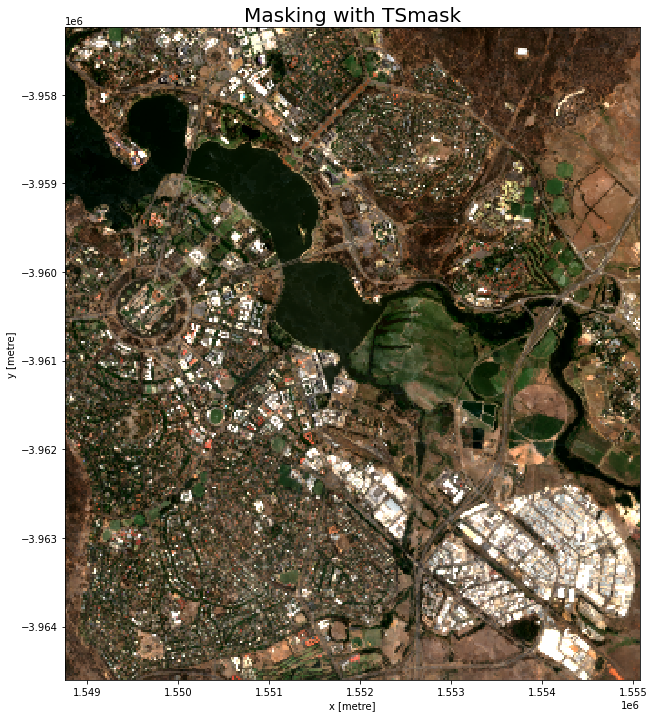

In [21]:
# Identify pixels that are "Clear"
cloud_free_mask = make_mask(tsmask_ds.classification, classification="valid")

# Apply mask to RGB bands
s2_masked = s2_ds[['nbart_red', 'nbart_green',
                   'nbart_blue']].where(cloud_free_mask)

# Generate mean composite
s2_mean = s2_masked.mean(dim='time')

# Plot in RGB
rgb(s2_mean, size=12)
plt.title('Masking with TSmask', fontdict={'fontsize': 20})

#### Exercise xxx: Similarly to the previous example. Can you create an averaged image for a city in Australia using the TSmask product.

> Note: Cloud masking is particularly tricky in cities, where certain rooftops present high reflectance values and are often missclassified by cloud detection algorithms. Persistence of high reflectance values over a time series allows to differentiate clouds from high reflectance surfaces.

In [ ]:
# use as many cells as you need

query = {?}

# Load in temporal cloudmask data
tsmask_ds = dc.load(product='s2_tsmask', 
                    progress_cbk=with_ui_cbk(),
                    **query)

# Load in Sentinel-2A and 2B data including fmask cloud masking band
s2a_ds = dc.load(
    product='s2a_ard_granule',
    measurements=['fmask', 'nbart_red', 'nbart_green', 'nbart_blue'],
    progress_cbk=with_ui_cbk(),
    **query)

s2b_ds = dc.load(
    product='s2b_ard_granule',
    measurements=['fmask', 'nbart_red', 'nbart_green', 'nbart_blue'],
    progress_cbk=with_ui_cbk(),
    **query)

# Combine Sentinel-2A and 2B data into a single dataset
s2_ds = xr.concat([s2a_ds, s2b_ds], dim='time').sortby('time')

???
???
???

#### Disclaimer: The original notebook for this tutorial has been taken from the Sandbox `Beginners_guide` folder. Refer to the conditions specified in the original notebook and for updated versions.